# Problem 2: Trapezoidal rule

In [1]:
%pylab inline
%matplotlib notebook
import time
import pandas

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


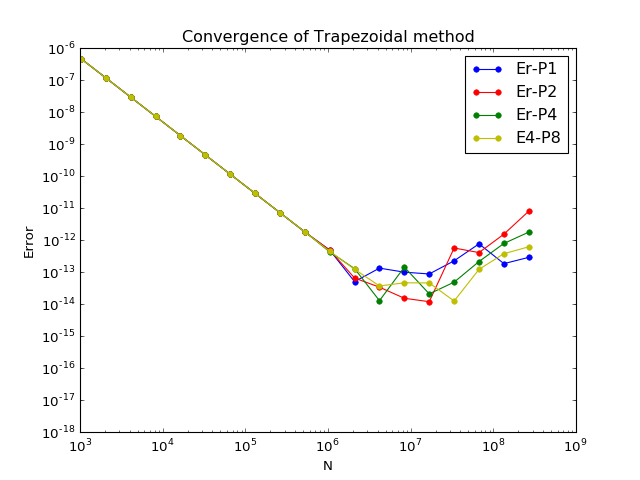

In [2]:
file_prefix = 'trap_'
nprocs = [2**i for i in range (0, 4)]
Nvec = []
soln = []
err = []
t = []
rate = []
counter = 0
for i in nprocs:
    filename = (file_prefix + '{:02d}'.format(i) + '.out')
    T = loadtxt(filename)
    time.sleep(0.1)
    Nvec.append(T[:,0].astype('int'))
    soln.append(T[:,1])
    err.append(T[:,2])
    t.append(T[:,3])
    rate.append(log2(abs(err[counter][:-1])/abs(err[counter][1:])).reshape(-1,1))

plt.loglog(Nvec[0],abs(err[0]),'b.-',markersize=10)
plt.loglog(Nvec[1],abs(err[1]),'r.-',markersize=10)
plt.loglog(Nvec[2],abs(err[2]),'g.-',markersize=10)
plt.loglog(Nvec[3],abs(err[3]),'y.-',markersize=10)

xlabel('N')
ylabel('Error')
title('Convergence of Trapezoidal method');

c = polyfit(log(Nvec[0][:-10]),log(abs(err[0][:-10])),1)
plt.loglog(Nvec,exp(polyval(c,log(Nvec))),'k-')
legend(["Er-P1","Er-P2","Er-P4","E4-P8"])

<hr/>

## Show results in a table

Create and print a Pandas table displaying results. We will add a column containing the convergence rate.

To compute the convergence rate, we assume that the error in our trapezoidal rule is given as a function of $h = (b-a)/N$.  

\begin{equation}
e(h) \sim Ch^r
\end{equation}

For a second order method, we expect the convergence rate $r$ to satisfy $r \sim 2$.  To numerically estimate $r$, we further assume that $e_i$ is the error computed using a mesh width $h$ and $e_{i+1}$ is the error on mesh width $h/2$.  Furthermore, for small $h$, we assume that the constant $C$ is independent of $h$.   Then, 
\begin{equation}
\frac{e_{i}}{e_{i+1}} = \frac{C h^r}{C(h/2)^r} \sim 2^r
\end{equation}

We can then compute the numerical converence rate $r_i$ as
\begin{equation}
r_i = \log_2\left(\frac{e_{i}}{e_{i+1}}\right)
\end{equation}
for errors $e_i$.  

In [3]:
df = pandas.DataFrame({'N' : Nvec[0],
                      'err0' : err[0],  'err1' : err[1], 'err2' : err[2], 'err3' : err[3],
                      't0'   : t[0],    't1'   : t[1],   't2'   : t[2],   't3'   : t[3]
                      })
di = {'err0' : 'Error P1',
      'err1' : 'Error P2',
      'err2' : 'Error P4',
      'err3' : 'Error P8',
      't0'   : 'Time P1 (s)',
      't1'   : 'Time P2 (s)',
      't2'   : 'Time P4 (s)',
      't3'   : 'Time P8 (s)'}

pr = df.rename(columns=di).style
exact_soln = 1.87259295726583875460;  # Copied from output
pr.set_caption("True solution is {:20.16f}".format(exact_soln))
pr

,N,Error P1,Error P2,Error P4,Error P8,Time P1 (s),Time P2 (s),Time P4 (s),Time P8 (s)
0,1024,-4.6778e-07,-4.6778e-07,-4.6778e-07,-4.6778e-07,0.0106,0.0103,0.0088,0.0255
1,2048,-1.1695e-07,-1.1695e-07,-1.1695e-07,-1.1695e-07,0.0099,0.0101,0.00873,0.0178
2,4096,-2.9236e-08,-2.9236e-08,-2.9236e-08,-2.9236e-08,0.00981,0.0111,0.01,0.0189
3,8192,-7.3091e-09,-7.3091e-09,-7.3091e-09,-7.3091e-09,0.00915,0.011,0.00987,0.0284
4,16384,-1.8273e-09,-1.8273e-09,-1.8273e-09,-1.8273e-09,0.00945,0.0105,0.00946,0.0191
5,32768,-4.568e-10,-4.5681e-10,-4.5682e-10,-4.5682e-10,0.00982,0.0117,0.00956,0.0211
6,65536,-1.1419e-10,-1.1419e-10,-1.1421e-10,-1.1421e-10,0.0114,0.0122,0.0113,0.0196
7,131072,-2.8565e-11,-2.8555e-11,-2.8544e-11,-2.8555e-11,0.0144,0.012,0.012,0.0172
8,262144,-7.1541e-12,-7.1376e-12,-7.1252e-12,-7.1319e-12,0.019,0.0156,0.0136,0.0243
9,524288,-1.769e-12,-1.7855e-12,-1.8101e-12,-1.785e-12,0.0286,0.0233,0.0147,0.0244


In [4]:
rate = []
for i in range(4):
    rate.append(log2(abs(err[i][:-1]/err[i][1:])))


df1 = pandas.DataFrame({'N'   : Nvec[0],
                      'rate0' : hstack((numpy.nan,rate[0])),
                      'rate1' : hstack((numpy.nan,rate[1])),
                      'rate2' : hstack((numpy.nan,rate[2])),
                      'rate3' : hstack((numpy.nan,rate[3]))})

di1 = {'rate0' : 'Rate P1',
       'rate1' : 'Rate P2',
       'rate2' : 'Rate P4',
       'rate3' : 'Rate P8'}

pr1 = df1.rename(columns=di1).style
pr1

,N,Rate P1,Rate P2,Rate P4,Rate P8
0,1024,nan,nan,nan,nan
1,2048,1.99994,1.99994,1.99994,1.99994
2,4096,2.00007,2.00007,2.00007,2.00007
3,8192,1.99998,1.99998,1.99998,1.99998
4,16384,1.99998,1.99998,1.99998,1.99998
5,32768,2.00008,2.00005,2.00002,2.00002
6,65536,2.00013,2.00016,1.99994,1.99994
7,131072,1.99912,1.99962,2.00043,1.99987
8,262144,1.99741,2.00023,2.00219,2.00139
9,524288,2.01584,1.99911,1.97686,1.99836


<hr/>
# Prob2 : Performance results
<hr/>

In [5]:
import numpy, pandas

file_prefix = 'trap_'

pdata = {}
nprocs = [1,2,4,8]
for p in nprocs:
    fname = file_prefix + '{:02d}'.format(p) + '.out'
    try:
        df = pandas.read_table(fname,names=['N','soln','err','t'],delim_whitespace=True)        
    except:
        print("File '{:s}' not found.".format(fname))
    else:
        tname = 'p' + '{:02d}'.format(p)       
        pdata[tname] = df
        
    
panel = pandas.Panel(pdata)

## Plot timing results

Using the Panel, we can easily plot all of the timing results in a single plot.  

<IPython.core.display.Javascript object>


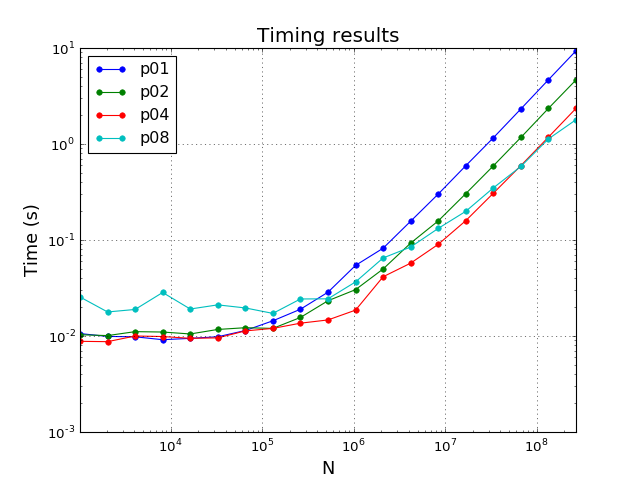

In [6]:
df_timing = panel.minor_xs('t') 
cols = ['N',*df_timing.columns]

df_timing['N'] = panel['p01']['N'].astype('int')
df_timing = df_timing[cols]
df_timing.plot(x='N',logx=True,logy=True,style='.-',markersize=10)

title("Timing results",fontsize=18);
xlabel("N",fontsize=16)
ylabel("Time (s)",fontsize=16)
grid(True)

<hr/>

## Strong scaling

If an algorithm scales well, we expect that adding more processors to a problem of fixed size should speed up the calculation.  If a code were "embarrassingly parallel", we expect two processors to take half as much time as one processor, 4 processors to take a quarter of the time, and so on.  We call this type of scaling "strong" scaling.  

For strong scaling, we compare timings for a fixed value of $N$.   We will choose one of the larger values to see better results.

In [7]:
idx = 18    # Choose N corresponding to index=18, 268435456.0 (This is the largest numbers of interval that was
            # tested)

N = int(panel['p01']['N'][idx])
procs = array([1,2,4,8])
df_strong = panel.major_xs(idx).transpose()    
df_strong['p'] = procs
df_strong[['p','soln','err','t']].style.set_caption("N = {:d}".format(N))

,p,soln,err,t
p01,1,1.87259,-2.869e-13,9.35
p02,2,1.87259,-7.9754e-12,4.65
p04,4,1.87259,1.7635e-12,2.35
p08,8,1.87259,6.131e-13,1.79


Plot the strong scaling results and show the best-fit line to get an estimate of the speed-up.  

<IPython.core.display.Javascript object>


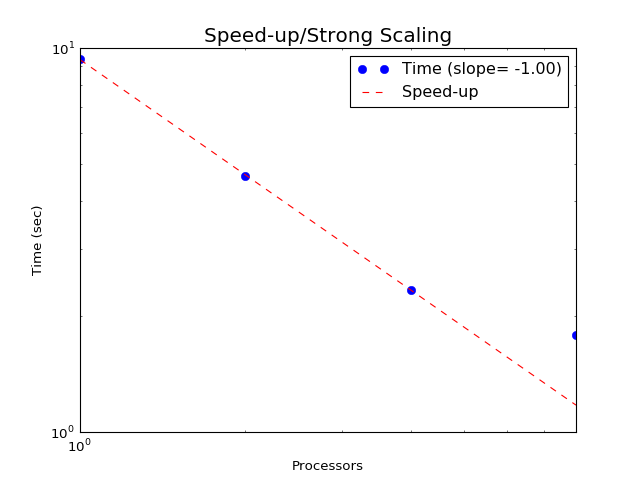

In [8]:
df_strong.plot(x='p',y='t',logx=True,logy=True,style='.',markersize=15)

# Plot best-fit speed-up line
t_strong = array(df_strong['t'])
c = polyfit(log(procs[:-1]),log(t_strong[:-1]),1)
plt.loglog(procs,exp(polyval(c,log(procs))),'r--')
xlabel('Processors')
ylabel('Time (sec)')
legend(['Time (slope={:6.2f})'.format(c[0]),'Speed-up'])
title('Speed-up/Strong Scaling',fontsize=18);

## Weak scaling

If an algorithm scales well, we expect to be able to solve bigger problems by adding more processors.  For example, if we double the size of the problem, and double the number of processors, we expect the code to take the same time as the original problem.  This sort of scaling is called "weak scaling".  

In [9]:
df_weak = panel.minor_xs('t')
df_weak

,p01,p02,p04,p08
0,0.01060,0.0103,0.00880,0.0255
1,0.00990,0.0101,0.00873,0.0178
2,0.00981,0.0111,0.01000,0.0189
3,0.00915,0.0110,0.00987,0.0284
4,0.00945,0.0105,0.00946,0.0191
5,0.00982,0.0117,0.00956,0.0211
6,0.01140,0.0122,0.01130,0.0196
7,0.01440,0.0120,0.01200,0.0172
8,0.01900,0.0156,0.01360,0.0243
9,0.02860,0.0233,0.01470,0.0244


<IPython.core.display.Javascript object>


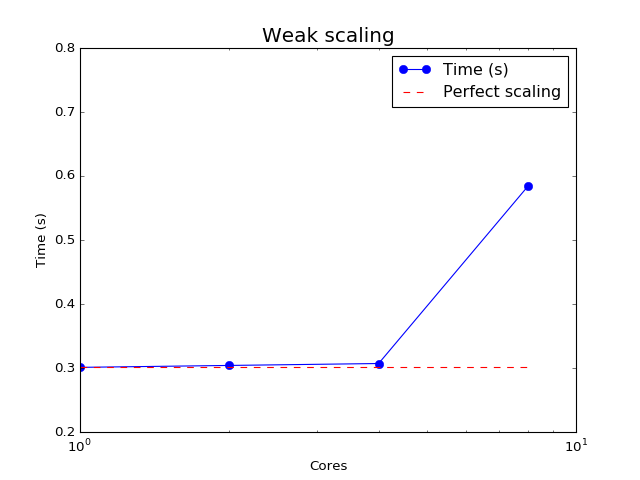

(0.2, 0.8)

In [10]:
figure()
clf()
idx = 14     # Start with 'N' index;  shift by one as we increase the processor count
t_weak = array([df_weak[c][13+i] for i,c in enumerate(df_weak.columns)])

semilogx(procs,t_weak,'.-',markersize=15)
semilogx(procs,[t_weak[0]]*4,'r--')
title('Weak scaling', fontsize=18)
xlabel('Cores')
ylabel("Time (s)")
legend(['Time (s)','Perfect scaling'])
ylim([0.20,0.80])


## Efficiency

When we add more processors, we expect some overhead associated with more communication.  This is captured somewhat in the weak scaling results, but what is not shown is how quickly the efficiency drops off.  

Efficiency plots can often highlight poor scaling reslts that are not obvious from strong scaling results.

<IPython.core.display.Javascript object>


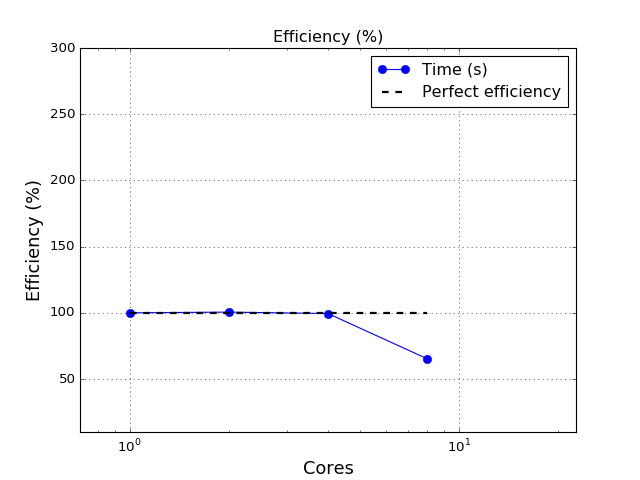

In [11]:
figure()
clf()

# Efficiency
E = t_strong[0]/(procs*t_strong)*100

semilogx(procs,E,'.-',markersize=15)
semilogx(procs,[100]*4,'k--',linewidth=2)

xlabel('Cores',fontsize=16)
ylabel('Efficiency (%)',fontsize=16)
title("Efficiency (%)");
legend(['Time (s)', 'Perfect efficiency'])
xlim([1/sqrt(2), 2**4.5])
ylim([10,300])
grid()

### Trapezoidal Rule

In [12]:
cat p2.c

#include "demo7.h"
#include <demo_util.h>
#include <mpi.h>
#include <math.h>

#define ROOT_PROCESSOR 0

/* Function Prototype */
double trapz(double low, double high, int n, double width);

/* Integrate this over [-1,1] */
double f(double x)
{
    double fx;
	fx = (x-1)*(x-1)*exp(-1*x*x);
    return fx;
}

/* Trapz function for integration */
double trapz(double low, double high, int n, double width)
{
	int i;
	double lowLimit = low;
    double integral = 0; // hold the value of integration
	integral = (f(low) + f(high)) / 2.0;
	
	for (i = 1; i < n; i++)
	{
		lowLimit = lowLimit + width;
		integral += f(lowLimit);
	}
	return integral*width;
}

void main(int argc, char** argv)
{
    int n_global;
	double range[2];
	double exact_ans = 1.87259295726583875460;
    /* MPI variables */
    int my_rank, nprocs;

    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &my_rank);
    set_rank(my_rank);  /* Used in printing */
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    if (my_rank ==